In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import copy
import time
import random
import skimage.transform as trans
from utils_warp import convert_image_np, normalize_transforms, rotatepoints, show_image

%matplotlib inline

0
<class 'numpy.ndarray'>
<class 'numpy.uint8'>
[199 191 188]
(480, 640, 3)


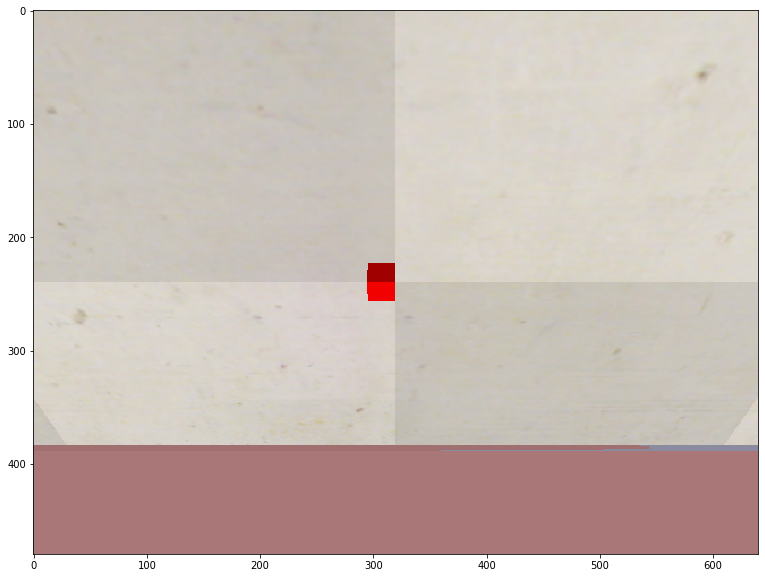

In [2]:
color_img = np.load('color_img.npy')

# color_img = color_img.astype(np.float)+127/255
# print(np.min(color_img))
# color_img = np.fliplr(color_img)
# color_img = color_img.astype(np.uint8)

color_img = color_img.astype(np.float)/255
color_img[color_img < 0] += 1
color_img *= 255
color_img = np.fliplr(color_img)
color_img = color_img.astype(np.uint8)

print(np.min(color_img))
print(type(color_img))
print(type(color_img[220][280][0]))
print((color_img[220][280]))
print(color_img.shape)
plt.figure(figsize=(20, 10))
plt.imshow(color_img)

4.94568
<class 'numpy.ndarray'>
<class 'numpy.float32'>
6.83989
(480, 640)


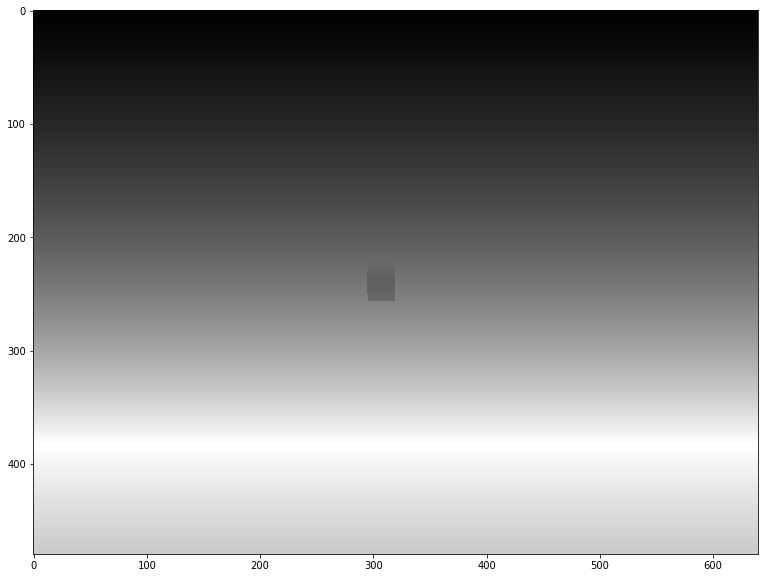

In [3]:
depth_img = np.load('depth_img.npy')

depth_img = np.fliplr(depth_img)
zNear = 0.01
zFar = 10
depth_img = depth_img * (zFar - zNear) + zNear

print(np.min(depth_img))
print(type(depth_img))
print(type(depth_img[0][0]))
print((depth_img[220][280]))
print(depth_img.shape)
plt.figure(figsize=(20, 10))
plt.imshow(depth_img, cmap='gray')

In [4]:
def get_pointcloud(color_img, depth_img, camera_intrinsics):
    # Get depth image size
    im_h = depth_img.shape[0]
    im_w = depth_img.shape[1]

    # Fake intrinsics for now

    # Project depth back into 3D point cloud in Camera coordinates (I think he means relative to camera frame)
    pix_x, pix_y = np.meshgrid(np.linspace(0, im_w-1, im_w), np.linspace(0, im_h-1, im_h))

    cam_pts_x = np.multiply(pix_x-camera_intrinsics[0][2], depth_img/camera_intrinsics[0][0])
    cam_pts_y = np.multiply(pix_y-camera_intrinsics[1][2], depth_img/camera_intrinsics[1][1])
    cam_pts_z = depth_img.copy()

    cam_pts_x.shape = (im_h*im_w, 1)
    cam_pts_y.shape = (im_h*im_w, 1)
    cam_pts_z.shape = (im_h*im_w, 1)

    # Reshape image into colors for 3D point cloud
    rgb_pts_r = color_img[:, :, 0].reshape((im_h*im_w, 1))
    rgb_pts_g = color_img[:, :, 1].reshape((im_h*im_w, 1))
    rgb_pts_b = color_img[:, :, 2].reshape((im_h*im_w, 1))

    # It does not matter what the internal values or xyz points of the cam pts are in relation
    # to the rgb points. The rgb points only relate the index to color. Position is irrelevant.
    cam_pts = np.concatenate((cam_pts_x, cam_pts_y, cam_pts_z), axis=1)
    rgb_pts = np.concatenate((rgb_pts_r, rgb_pts_g, rgb_pts_b), axis=1)

    return cam_pts, rgb_pts


def get_heightmap(color_img, depth_img, cam_intrinsics, cam_pose, workspace_limits, heightmap_resolution):

    # Compute heightmap size
    heightmap_size = np.round(((workspace_limits[1][1] - workspace_limits[1][0])/heightmap_resolution, (workspace_limits[0][1] - workspace_limits[0][0])/heightmap_resolution)).astype(int)

    # Get 3D point cloud from RGB-D images
    surface_pts, color_pts = get_pointcloud(color_img, depth_img, cam_intrinsics)

    # Transform 3D point cloud from camera coordinates to robot coordinates
    surface_pts = np.transpose(np.dot(cam_pose[0:3,0:3],np.transpose(surface_pts)) + np.tile(cam_pose[0:3,3:],(1,surface_pts.shape[0])))
    
    # Sort surface points by z value
    sort_z_ind = np.argsort(surface_pts[:,2])
    surface_pts = surface_pts[sort_z_ind]
    color_pts = color_pts[sort_z_ind]
    
    # Filter out surface points outside heightmap boundaries
    heightmap_valid_ind = np.logical_and(np.logical_and(np.logical_and(np.logical_and(surface_pts[:,0] >= workspace_limits[0][0], surface_pts[:,0] < workspace_limits[0][1]), surface_pts[:,1] >= workspace_limits[1][0]), surface_pts[:,1] < workspace_limits[1][1]), surface_pts[:,2] < workspace_limits[2][1])
    surface_pts = surface_pts[heightmap_valid_ind]
    color_pts = color_pts[heightmap_valid_ind]
    
    # Create orthographic top-down-view RGB-D heightmaps
    color_heightmap_r = np.zeros((heightmap_size[0], heightmap_size[1], 1), dtype=np.uint8)
    color_heightmap_g = np.zeros((heightmap_size[0], heightmap_size[1], 1), dtype=np.uint8)
    color_heightmap_b = np.zeros((heightmap_size[0], heightmap_size[1], 1), dtype=np.uint8)
    depth_heightmap = np.zeros(heightmap_size)
    heightmap_pix_x = np.floor((surface_pts[:,0] - workspace_limits[0][0])/heightmap_resolution).astype(int)
    heightmap_pix_y = np.floor((surface_pts[:,1] - workspace_limits[1][0])/heightmap_resolution).astype(int)
    color_heightmap_r[heightmap_pix_y,heightmap_pix_x] = color_pts[:,[0]]
    color_heightmap_g[heightmap_pix_y,heightmap_pix_x] = color_pts[:,[1]]
    color_heightmap_b[heightmap_pix_y,heightmap_pix_x] = color_pts[:,[2]]
    color_heightmap = np.concatenate((color_heightmap_r, color_heightmap_g, color_heightmap_b), axis=2)
    depth_heightmap[heightmap_pix_y,heightmap_pix_x] = surface_pts[:,2]
    z_bottom = workspace_limits[2][0]
    depth_heightmap = depth_heightmap - z_bottom
    depth_heightmap[depth_heightmap < 0] = 0
    depth_heightmap[depth_heightmap == -z_bottom] = np.nan
#     print('len(depth_heightmap == -z_bottom) = {}'.format(len(depth_heightmap == -z_bottom)))
#     print('Any nan values in depth_heightmap: {}'.format(np.any(depth_heightmap == np.nan, 1)))

    return color_heightmap, depth_heightmap


def get_rotated_img(img_tensor, theta_in_rad):
    img = img_tensor
    theta = theta_in_rad
    theta_affine_matrix = np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0]])
    theta_affine_matrix = theta_affine_matrix.reshape(2, 3, 1)
    theta_affine_matrix = torch.from_numpy(theta_affine_matrix).permute(2, 0, 1).float()
    affine_grid = F.affine_grid(theta_affine_matrix, size=img.size())
    rotated_img = F.grid_sample(img, affine_grid, mode='nearest')
    
    return rotated_img


# def rotate(img):
#     row, col, channel = img.shape
#     angle = np.random.uniform(-15, 15)
#     rotation_point = (row / 2, col / 2)
#     rotation_matrix = cv2.getRotationMatrix2D(rotation_point, angle, 1)
#     rotated_img = cv2.warpAffine(img, rotation_matrix, (col, row))
    
# #     rot_mat = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), 45, 1)
# #     warp_rotate_dst = cv2.warpAffine(cv2.UMat(img),rot_mat, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST).get()

#     return rotated_img 




<IPython.core.display.Javascript object>


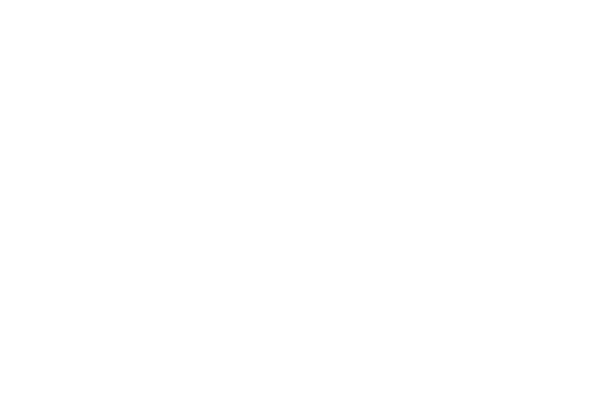

<IPython.core.display.Javascript object>


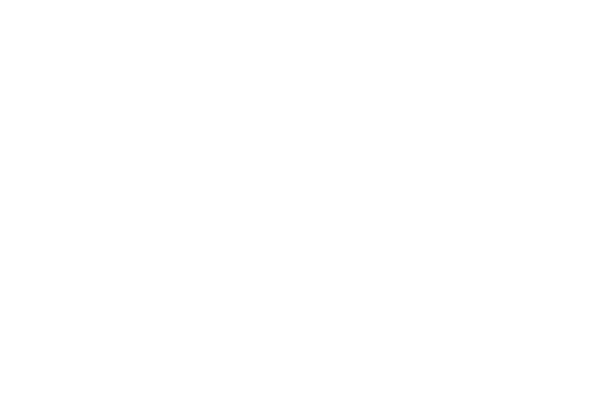

In [5]:
%matplotlib notebook
cam_intrinsics = np.asarray([[618.62, 0, 320], [0, 618.62, 240], [0, 0, 1]])
cam_pts, rgb_pts = get_pointcloud(color_img, depth_img, cam_intrinsics)

# Camera pose with respect to the global frame
cam_pose = np.asarray([[1, 0, 0, 0], 
[0, -0.7071069478988647, -0.7071068286895752, 1], 
[0, 0.7071068286895752, -0.7071069478988647, 0.5]])

cam_pts = np.transpose(np.dot(cam_pose[:3, :3], np.transpose(cam_pts)) + np.tile(cam_pose[:3, 3].reshape(-1, 1), (1, cam_pts.shape[0])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(cam_pts[:, 0], cam_pts[:, 1], cam_pts[:, 2])

(200, 200)
(200, 200, 3)
0


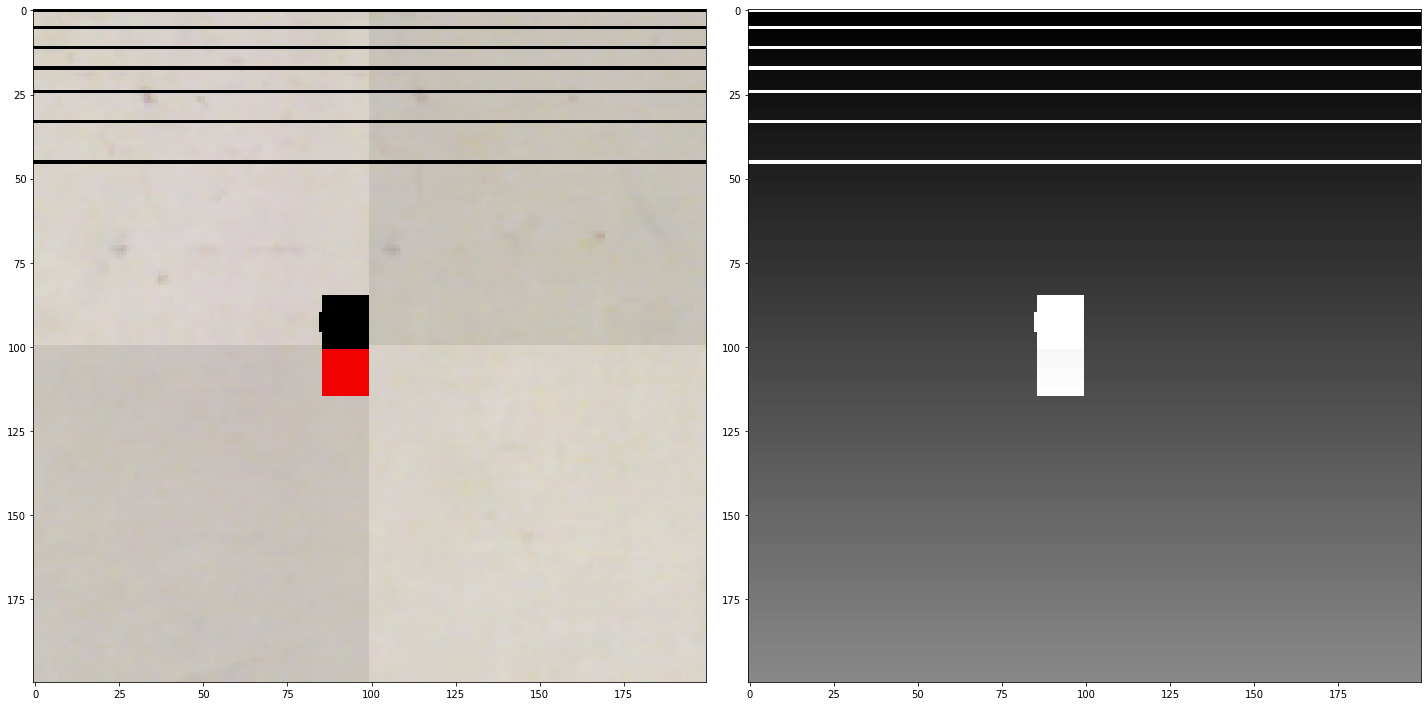

In [6]:
%matplotlib inline


cam_intrinsics = np.asarray([[618.62, 0, 320], [0, 618.62, 240], [0, 0, 1]])
# cam_intrinsics = [[463.889, 0, 320], [0, 463.889, 240], [0, 0, 1]]
# workspace_limits = np.asarray([[-0.724, -0.276], [-0.224, 0.224], [-0.0001, 0.4]]) # Cols: min max, Rows: x y z (define workspace limits in robot coordinates)
# workspace_limits = np.asarray([[0.3, 0.748], [-0.224, 0.224], [-0.255, -0.1]])
# workspace_limits = np.asarray([[0.3, 0.748], [0.05, 0.4], [-0.2, -0.1]])
workspace_limits = np.asarray([[-2, 2], [-6, -2], [-5, -4]])
heightmap_resolution = 0.02


cam_pose = np.asarray([[ 1, 0, 0, 0], [ 0, -0.70710679, -0.70710678, 1], [ 0, 0.70710678, -0.70710679, 0.5]])

# cam_pts, rgb_pts = get_pointcloud(color_img, depth_img, cam_intrinsics)
color_heightmap, depth_heightmap = get_heightmap(color_img, depth_img, cam_intrinsics, cam_pose, workspace_limits, heightmap_resolution)

print(depth_heightmap.shape)
print(color_heightmap.shape)
print(len(depth_heightmap[depth_heightmap == np.nan]))
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
f.tight_layout()
ax[0].imshow(color_heightmap)
ax[1].imshow(depth_heightmap, cmap='gray')

# Don't forget that there was another gradient for the rotated depth image that was somewhat darker.

img nanmin:  0.3803659993429376
img nanmax:  0.789140473162484
(200, 200, 1)
img nanmin:  0.380366
img nanmax:  0.78914046
rotated_img nanmin:  0.0
rotated_img nanmax:  0.78914046
old_img min:  0.380366
old_img max:  0.78914046


/home/mohamed/drive/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/mohamed/drive/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


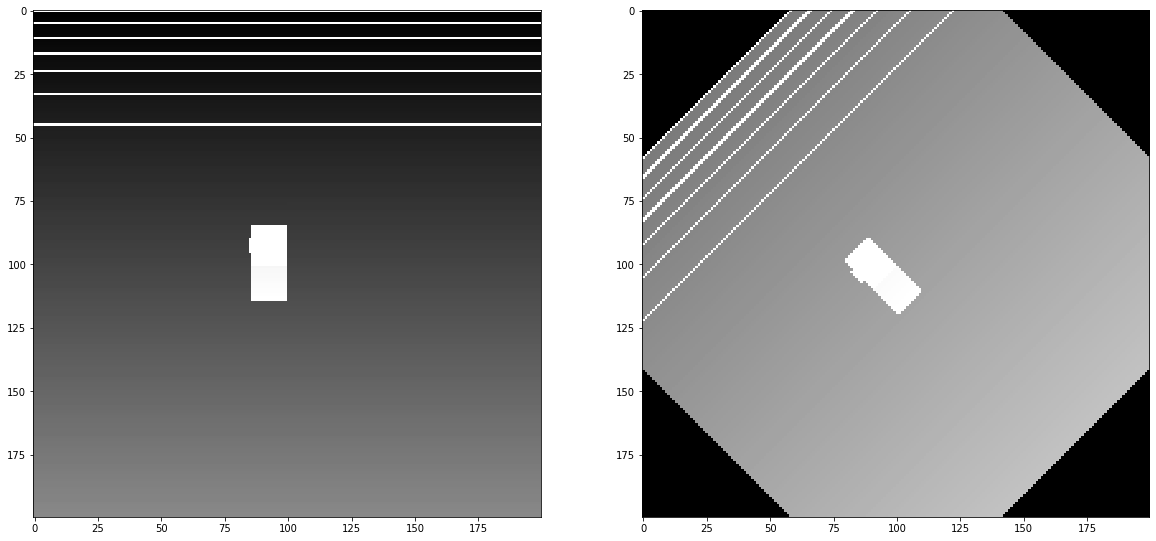

In [7]:
img = copy.deepcopy(depth_heightmap)
img = img.reshape((img.shape[0], img.shape[1], -1))
print("img nanmin: ", np.nanmin(img))
print("img nanmax: ", np.nanmax(img))

print(img.shape)
img = img.reshape((1, img.shape[2], img.shape[0], img.shape[1]))
img = torch.from_numpy(img).float()
print("img nanmin: ", np.nanmin(img))
print("img nanmax: ", np.nanmax(img))

theta = -np.radians(45)
rotated_img = get_rotated_img(img, theta)
rotated_img = rotated_img.squeeze(0).numpy().transpose(1, 2, 0).squeeze()
print("rotated_img nanmin: ", np.nanmin(rotated_img))
print("rotated_img nanmax: ", np.nanmax(rotated_img))

old_img = img.numpy().reshape((img.shape[2], img.shape[3], img.shape[1])).squeeze()
print("old_img min: ", np.nanmin(old_img))
print("old_img max: ", np.nanmax(old_img))



f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[1].imshow(rotated_img, cmap='gray')
ax[0].imshow(old_img, cmap='gray')


img.min(): 0.0
img.max(): 0.9490196108818054
rotated img.min(): 0.0
rotated img.max(): 0.9490196108818054


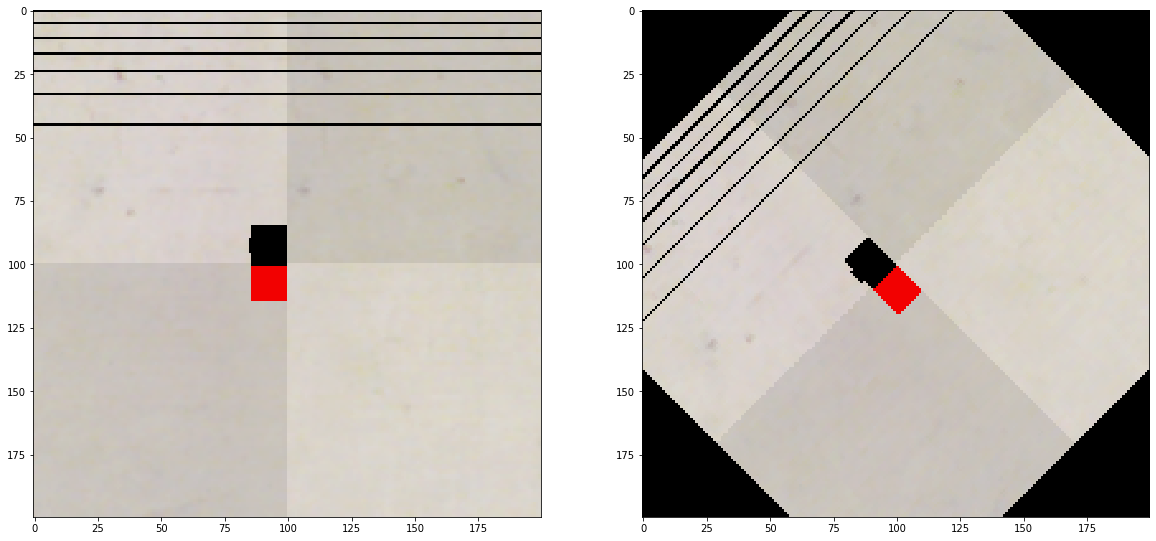

In [8]:
img = copy.deepcopy(color_heightmap)

img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()/255
print('img.min(): {}'.format(img.min()))
print('img.max(): {}'.format(img.max()))

theta = -np.radians(45)
rotated_img = get_rotated_img(img, theta)
rotated_img = rotated_img.squeeze(0).numpy().transpose(1, 2, 0)
print('rotated img.min(): {}'.format(img.min()))
print('rotated img.max(): {}'.format(img.max()))


f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
# ax[0].imshow((img.numpy().squeeze().transpose(1, 2, 0)*255).astype(np.uint8))
ax[0].imshow((img.numpy().squeeze().transpose(1, 2, 0)))
ax[1].imshow(rotated_img)

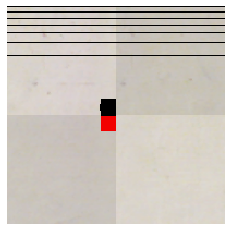

torch.Size([1, 3, 200, 200])


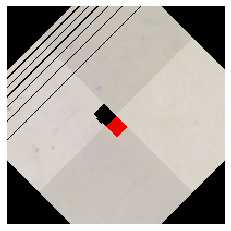

In [9]:


"""1. Load image and landmarks"""
image = copy.deepcopy(color_heightmap)
show_image(image)



# """5.Warp image to tensor_img using grid_sample"""
to_tensor = torchvision.transforms.ToTensor()
# tensor_img = to_tensor(image).unsqueeze(0)
tensor_img = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()/255
print(tensor_img.shape)

theta = -np.radians(45)
theta_affine_matrix = np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0]])
theta_affine_matrix = theta_affine_matrix.reshape(2, 3, 1)
theta_affine_matrix = torch.from_numpy(theta_affine_matrix).permute(2, 0, 1).float()

grid = F.affine_grid(theta_affine_matrix, tensor_img.size())
tensor_img = F.grid_sample(tensor_img, grid, mode='nearest')
tensor_img = tensor_img.squeeze(0)
warp_img = convert_image_np(tensor_img)
show_image(warp_img)


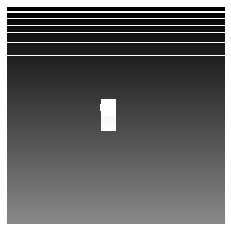

torch.Size([1, 1, 200, 200])


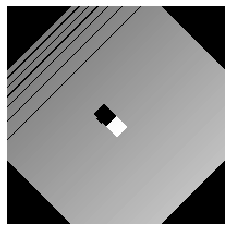

In [10]:
image = copy.deepcopy(depth_heightmap)
show_image(image, gray=True)


to_tensor = torchvision.transforms.ToTensor()
# tensor_img = to_tensor(image).unsqueeze(0).float()
tensor_img = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()
print(tensor_img.size())

grid = F.affine_grid(theta_affine_matrix, tensor_img.size())
tensor_img = F.grid_sample(tensor_img, grid, mode='nearest')
tensor_img = tensor_img.squeeze(0)
warp_img = convert_image_np(tensor_img)
show_image(warp_img.squeeze(), gray=True)